In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

In [40]:
model = np.genfromtxt(
    # Kerr 0.9
    '/Users/hombit/Documents/projects/accretion/fred/data/F_1.9829e+38/alpha_0.64902/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.8954e+38/alpha_0.88938/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.8485e+38/alpha_0.99979/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.7979e+38/alpha_1.27575/sum.dat',
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_1.7347e+38/alpha_1.4379/sum.dat',
    # Kerr 0.9, Tph=8000
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_9.8653e+37/alpha_0.99589/sum.dat',
    # Kerr 0.6
    #'/Users/hombit/Documents/projects/accretion/fred/data/F_2.5947e+38/alpha_0.82624/sum.dat',
    names=True
)
obsB = np.genfromtxt(
    '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/data_and_plots/opt/f1_B.txt',
    names=['t','mB'],
    delimiter=', '
)
obsV = np.genfromtxt(
    '/Users/hombit/Dropbox/X-ray_novae_modeling (2) (1)/data_and_plots/opt/f1_Vall.txt',
    names=['t','mV'],
    delimiter=', '
)
model['t'] -= 5.52
obsB['t'] -= 52445.5
obsV['t'] -= 52445.5

AV = 1.6
AB = 1.324 * 1.6

obsB['mB'] -= AB
obsV['mV'] -= AV

<IPython.core.display.Javascript object>


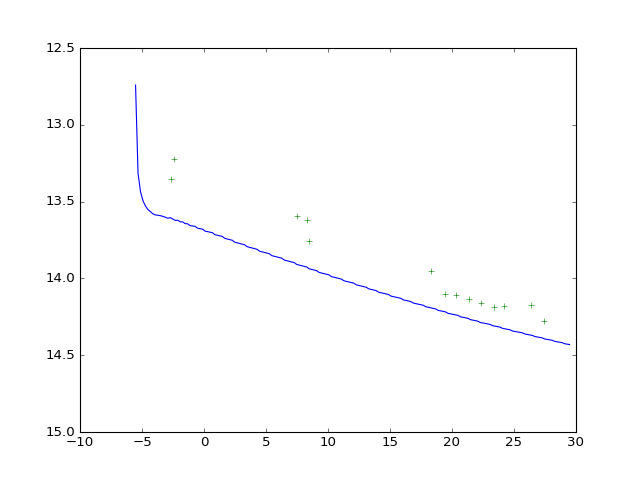

In [41]:
mV_cold = -2.5 * np.log10( 1 - (model['Rhot2Rout']-1e-9)**2. ) + 10000
backgroundV = obsV['mV'][ obsV['t'] < -50 ].mean()
mV_sum = -2.5 * np.log10(
    + np.power(10., -0.4 * model['mV'])
    + np.power(10., -0.4 * mV_cold)
    + np.power(10., -0.4 * backgroundV)
)
plt.gca().invert_yaxis()
#plt.ylim([14.3,13.7])
plt.xlim([-10,30])
plt.plot( model['t'], mV_sum )
plt.plot( obsV['t'], obsV['mV'], '+' )